In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms

%matplotlib inline

In [4]:
def display_image_annot(img, annts):
    img = io.imread(img['coco_url']) if isinstance(img, dict) else img
    if not annts:
        raise('Annotation is empty')
    for annt in annts:
        if 'bbox' in annt:
            bbox = np.ascontiguousarray(annt['bbox']).astype(np.int)
            img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 3)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
def display_bbox_annot(img, bboxes):
    img = io.imread(img['coco_url']) if isinstance(img, dict) else img
    for bbox in bboxes:
        bbox = bbox.astype(np.int)
        img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (0, 255, 0), 3)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

class CocoDataset(Dataset):
    def __init__(self, root, data_type, transforms, in_memory=False, is_debug=False):
        self.data_type = data_type
        self.transforms = transforms
        self.in_memory = in_memory
        self.is_debug = is_debug
        data_type = data_type.split('/')[-1]
        annts_file = f'{ root }/annotations/instances_{ data_type }.json'
        self.coco = COCO(annts_file)
        
        # Note: In theory, ensures persons presence.
        category_ids = self.coco.getCatIds(catNms=['person'])
        image_ids = self.coco.getImgIds(catIds=category_ids)
        self.image_meta = self.coco.loadImgs(image_ids)
        
        self.images = []; self.annts = []
        for image_meta_data in self.image_meta:
            annts_ids = self.coco.getAnnIds(imgIds=image_meta_data['id'], catIds=category_ids, iscrowd=False)
            img = io.imread(image_meta_data['coco_url']) if self.in_memory else image_meta_data
            self.images.append(img)
            self.annts.append(self.coco.loadAnns(annts_ids))
        
        if self.is_debug and len(self.images) > 0 and len(self.annts) > 0:
            idx = np.random.randint(0, len(self.images) - 1)
            display_image_annot(self.images[idx], self.annts[idx])
            
        self.n = len(self.images)
        
    def __getitem__(self, idx):
        img = self.images[idx] if self.in_memory else io.imread(self.images[idx]['coco_url'])
        bboxes = [ annt['bbox'] for annt in self.annts[idx] if 'bbox' in annt ]
        bboxes = None if len(bboxes) == 0 else np.array(bboxes)
        
        if self.is_debug and bboxes.shape[0] > 0:
            display_bbox_annot(self.images[idx], bboxes)
            
        if not self.transforms:
            self.transforms = transforms.ToTensor()
            
        img_tensor = self.transforms(img).float()
        bboxes_tensor = torch.from_numpy(bboxes).float() if bboxes.shape[0] > 0 else None
        
        return img_tensor, bboxes_tensor
    
    def __len__(self):
        return self.n

loading annotations into memory...
Done (t=13.89s)
creating index...
index created!


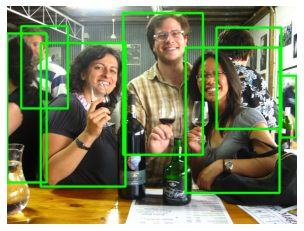

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [6]:
root = 'coco'
img_paths = 'images'
train_dataset = CocoDataset(root, data_type=os.path.join(root, 'train2017'), transforms=None, in_memory=False, is_debug=True)
val_dataset = CocoDataset(root, data_type=os.path.join(root, 'val2017'), transforms=None)

In [24]:
import multiprocessing as mp
import torch.backends.cudnn as cudnn

print(f'Usable threads: { torch.get_num_threads() }')
print(f'cuda version: { torch.cuda.version() }\tcudnn version: { cudnn.version() }')

num_workers = (0.4 * mp.cpu_count())
train_loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, pin_memory=True, num_workers=num_workers)

Usable threads: 12


AttributeError: module 'torch.cuda' has no attribute 'version'